In [2]:
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
fig_path      = '../figures/'
data_path     = '../data/'

In [3]:
import numpy as np
import xarray as xr
import os
import sys
from os.path import join,expanduser
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..', '..', 'ECCO-v4-Python-Tutorial')))
import ecco_access as ea
user_home_dir = expanduser('~')
import xgcm

In [4]:
import ecco_v4_py as ecco
import warnings

## (1) Open ECCO files

In [5]:
ds_ecco = xr.open_dataset(data_path + 'ecco_all_tiles_velocities.nc')              #velocities
ds_geom = xr.open_dataset(data_path + 'GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc') #geometry

## (2) Define transect points

In [372]:
p1 = [-54.85, 53.00] #[-56, 51]
p2 = [-46.90, 55.50] #[-45, 60]

## (3) Make masks 

In [373]:
warnings.simplefilter(action='ignore', category=FutureWarning)
maskC, maskW, maskS = ecco.get_section_line_masks(p1,p2,ds_ecco)

## (4) Center velocities

In [8]:
u_centered = 0.5 * (ds_ecco.UVEL.isel(time = 0, i_g=slice(0, -1)) + ds_ecco.UVEL.isel(time = 0, i_g=slice(1, None)))
v_centered = 0.5 * (ds_ecco.VVEL.isel(time = 0, j_g=slice(0, -1)) + ds_ecco.VVEL.isel(time = 0, j_g=slice(1, None)))

for t in range(1, len(ds_ecco.time)):
    print(t)
    u_temp = 0.5 * (ds_ecco.UVEL.isel(time = t, i_g=slice(0, -1)) + ds_ecco.UVEL.isel(time = t, i_g=slice(1, None)))
    v_temp = 0.5 * (ds_ecco.VVEL.isel(time = t, j_g=slice(0, -1)) + ds_ecco.VVEL.isel(time = t, j_g=slice(1, None)))

    u_centered = xr.concat([u_centered,u_temp], dim = 'time')
    v_centered = xr.concat([v_centered,v_temp], dim = 'time')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [357]:
u_centered = u_centered.rename({'i_g': 'i'}) 
v_centered = v_centered.rename({'j_g': 'j'})

## (4) Apply masks to velocity

In [374]:
maskC = maskC.sel(j = slice(1,88), i = slice(1,88))

In [375]:
uvel_tile11  = u_centered.sel(tile=10).squeeze()
vvel_tile11  = v_centered.sel(tile=10).squeeze()

uvel_tile11 = uvel_tile11.sel(j = slice(1,88), i = slice(1,88))
vvel_tile11 = vvel_tile11.sel(j = slice(1,88), i = slice(1,88))

maskC_tile11 = maskC.sel(tile=10).squeeze()
maskC_tile11 = maskC_tile11.where(maskC_tile11 > 0.01, np.nan)
maskC_tile11 = maskC_tile11.expand_dims({'time':len(uvel_tile11.time)})
maskC_tile11 = maskC_tile11.expand_dims({'k':len(uvel_tile11.k)})

uvel_masked  = maskC_tile11*uvel_tile11
vvel_masked  = maskC_tile11*vvel_tile11

## (5) Put only points on transect into array

In [376]:
valid_mask      = ~uvel_masked.isnull().all(dim=['k', 'time'])
stacked         = valid_mask.stack(points=('j', 'i'))
valid_points    = stacked.where(stacked, drop=True)
transect_coords = list(zip(valid_points['i'].values, valid_points['j'].values))
transect_coords = transect_coords[1:]

In [377]:
transect_data = []
for i, j in transect_coords:
    vel = uvel_masked.isel(j=j-1, i=i - 1)  # shape: (time,)
    transect_data.append(vel)

# Combine into single DataArray along a new 'point' dimension
transect_array = xr.concat(transect_data, dim='point')

# Add coordinates to help track where each point came from
transect_u = transect_array.assign_coords({
    'point': np.arange(len(transect_coords)),
    'i': ('point', [i for i, j in transect_coords]),
    'j': ('point', [j for i, j in transect_coords])
})

In [378]:
valid_mask      = ~vvel_masked.isnull().all(dim=['k', 'time'])
valid_points    = valid_mask.stack(points=('j', 'i')).where(valid_mask.stack(points=('j', 'i')))
valid_points    = valid_points.dropna('points')
transect_coords = list(zip(valid_points['j'].values, valid_points['i'].values))
transect_coords = [(y, x) for (x, y) in transect_coords]

In [379]:
transect_data = []
for i, j in transect_coords:
    vel = vvel_masked.isel(i=i-1,j=j-1)  # shape: (time,)
    transect_data.append(vel)

# Combine into single DataArray along a new 'point' dimension
transect_array = xr.concat(transect_data, dim='point')

# Add coordinates to help track where each point came from
transect_v = transect_array.assign_coords({
    'point': np.arange(len(transect_coords)),
    'i': ('point', [i for i, j in transect_coords]),
    'j': ('point', [j for i, j in transect_coords])
})

In [380]:
bathy_tile_11 = ds_geom.Depth.isel(tile = 10)
bathy_tile_11 = bathy_tile_11.sel(j = slice(1,88), i = slice(1,88))

In [381]:
transect_bathy = [] 
for i, j in transect_coords:
    bathy = bathy_tile_11.isel(i=i-1,j=j-1)  # shape: (time,)
    transect_bathy.append(bathy)

# Combine into single DataArray along a new 'point' dimension
bathy_array = xr.concat(transect_bathy, dim='point')

# Add coordinates to help track where each point came from
bathy = bathy_array.assign_coords({
    'point': np.arange(len(transect_coords)),
    'i': ('point', [i for i, j in transect_coords]),
    'j': ('point', [j for i, j in transect_coords])
})

In [390]:
ecco_tile_11 = ds_ecco.isel(tile = 10)
ecco_tile_11 = ecco_tile_11.sel(j = slice(1,88), i = slice(1,88))

In [396]:
transect_lat = [] 
transect_lon = [] 

for i, j in transect_coords:
    lat = ecco_tile_11.YC.isel(i=i-1,j=j-1)  # shape: (time,)
    lon = ecco_tile_11.XC.isel(i=i-1,j=j-1) 
    transect_lat.append(lat.data)
    transect_lon.append(lon.data)

# Combine into single DataArray along a new 'point' dimension
#bathy_array = xr.concat(transect_bathy, dim='point')

# Add coordinates to help track where each point came from
#bathy = bathy_array.assign_coords({
#    'point': np.arange(len(transect_coords)),
#    'i': ('point', [i for i, j in transect_coords]),
#    'j': ('point', [j for i, j in transect_coords])
#})

## (6) Rotate points to be normal to transect

In [382]:
dy = p2[0] - p1[0]
dx = p2[1] - p1[1]
theta = np.arctan2(dy, dx)

In [383]:
u_across = -transect_u * np.sin(theta) + transect_v * np.cos(theta)
u_along  =  transect_u * np.cos(theta) + transect_v * np.sin(theta)

## (7) Convert to lat/lon

In [399]:
u_across = u_across.rename({'Z': 'depth'})
u_along  = u_along.rename({'Z': 'depth'})

In [400]:
bathy    = bathy.rename({'XC': 'longitude','YC': 'latitude'})

## (8) Plotting 

In [425]:
import seaborn as sns
import cmocean as cmo

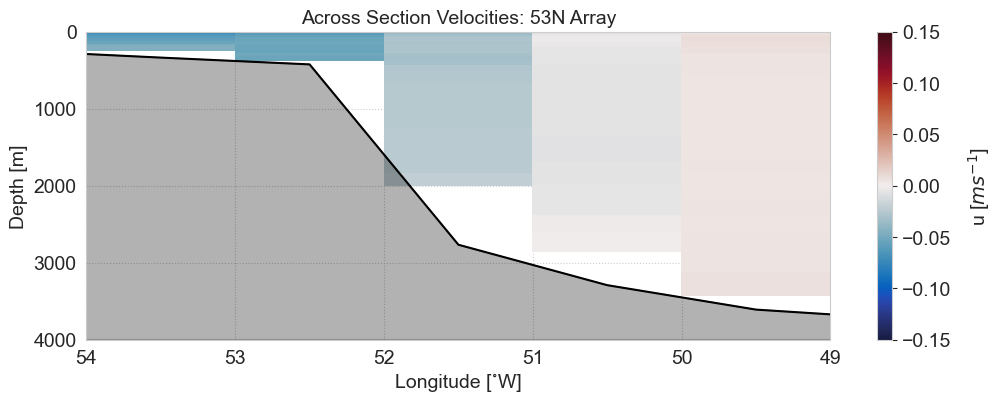

In [452]:
# --- Plot transect across western face ---
save_name    = 'velocity_transect_west_lat_lon'
sns.set_style('whitegrid',{"grid.linestyle": ":"})

fig  = plt.figure(figsize=[12,4])

tit = plt.title('Across Section Velocities: 53N Array', fontsize=14)

pcol  = plt.pcolor(np.array(transect_lon[:-1]), u_across.depth, u_across.mean(dim = 'time').T, cmap='cmo.balance', vmin = -0.15, vmax = 0.15)

cbar  = plt.colorbar()
clab_ = cbar.set_label('u [$ms^{-1}$]',  fontsize = 14,labelpad=11)
ctix_ = cbar.ax.tick_params(labelsize=14)

bat_ = plt.plot(bathy.longitude,bathy,'k')
batfill_ = plt.fill_between(bathy.longitude,-4000, bathy,color = 'k',alpha = 0.3)

xtix_ = plt.xticks(np.arange(-54,-48), labels = np.arange(49,55)[::-1], fontsize = 14)
ytix_ = plt.yticks(np.arange(-4000,1,1000), labels = np.arange(0,4001,1000)[::-1], fontsize = 14)

xlab_ = plt.xlabel('Longitude [˚W]', fontsize = 14)
ylab_ = plt.ylabel('Depth [m]',fontsize = 14)
xlim_ = plt.xlim(-54,-49)
ylim_ = plt.ylim(-4000,0)
#plt.savefig(fig_path  + save_name + '.png', format='png', bbox_inches="tight",dpi=100)

In [ ]:
# --- Separations by depth ---
# LSW   0400 m - 1850 m
# NEADW 1850 m - 2800 m
# DSOW  2800 m - BOT
# LNADW 1850 m - BOT

In [454]:
c_nadw  = '#648fff'
c_lsw   = '#785ef0'
c_neadw = '#dc267f'
c_dsow  = '#fe6100'
c_lnadw = '#ffb000'

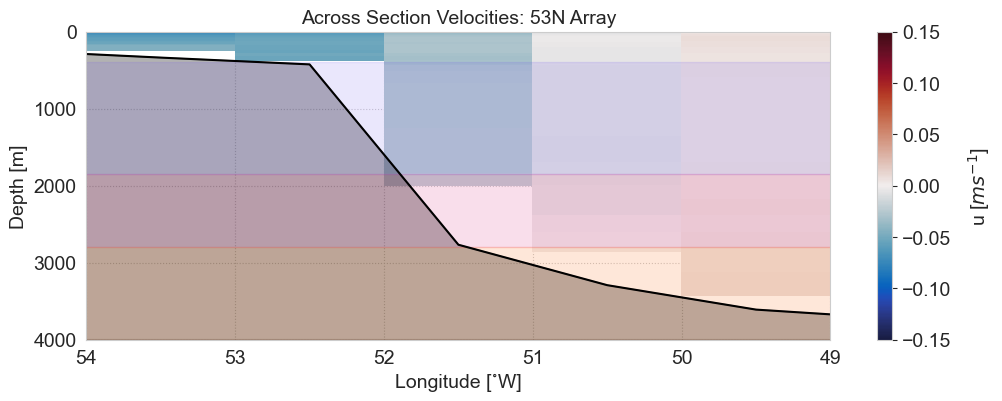

In [469]:
# --- Plot transect across western face ---
save_name    = 'velocity_transect_west_lat_lon'
sns.set_style('whitegrid',{"grid.linestyle": ":"})

fig  = plt.figure(figsize=[12,4])

tit = plt.title('Across Section Velocities: 53N Array', fontsize=14)

pcol  = plt.pcolor(np.array(transect_lon[:-1]), u_across.depth, u_across.mean(dim = 'time').T, cmap='cmo.balance', vmin = -0.15, vmax = 0.15)

cbar  = plt.colorbar()
clab_ = cbar.set_label('u [$ms^{-1}$]',  fontsize = 14,labelpad=11)
ctix_ = cbar.ax.tick_params(labelsize=14)

bat_ = plt.plot(bathy.longitude,bathy,'k')
batfill_ = plt.fill_between(bathy.longitude,-4000, bathy,color = 'k',alpha = 0.3)

xtix_ = plt.xticks(np.arange(-54,-48), labels = np.arange(49,55)[::-1], fontsize = 14)
ytix_ = plt.yticks(np.arange(-4000,1,1000), labels = np.arange(0,4001,1000)[::-1], fontsize = 14)

xlab_ = plt.xlabel('Longitude [˚W]', fontsize = 14)
ylab_ = plt.ylabel('Depth [m]',fontsize = 14)
xlim_ = plt.xlim(-54,-49)
ylim_ = plt.ylim(-4000,0)

lsw_fill   = plt.fill_between(bathy.longitude, -1850, -400,  color = c_lsw,  alpha = 0.15)
neadw_fill = plt.fill_between(bathy.longitude, -2800, -1850, color = c_neadw,alpha = 0.15)
dsow_fill  = plt.fill_between(bathy.longitude, -4000, -2800, color = c_dsow, alpha = 0.15)




#plt.savefig(fig_path  + save_name + '.png', format='png', bbox_inches="tight",dpi=100)

## (9) Save everything to netcdf because I would rather die than redo this

In [471]:
u_centered.to_netcdf(data_path + 'u_centered_tile11.nc')
v_centered.to_netcdf(data_path + 'v_centered_tile11.nc')

In [472]:
u_across.to_netcdf(data_path + 'u_across_53N.nc')
u_along.to_netcdf(data_path + 'u_along_53N.nc')